In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import pandas as pd
import numpy as np
import os
import pybedtools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import tnrange, tqdm_notebook

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/pass4/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/pass4/'

# other useful locations
motif_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/GCATG_RBFOX_MOTIF_POSITIONS_ALL.bed'
# peak_file = '/home/bay001/projects/kris_apobec_20200121/reference_data/SLBP_K562_IDR.bed'
# peak_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20200228_kris_eclip/IDR/kris_apobec/results/PAPO1.vs.PAPO2.bed'
# peak_file = '/home/elvannostrand/data/clip/CLIPseq_analysis/seCLIP/seRBFOX2_B_01.basedon_seRBFOX2_B_01.peaks.l2inputnormnew.bed.compressed.bed'
# peak_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_1/inputs/seRBFOX2_A_01.basedon_seRBFOX2_A_01.peaks.l2inputnormnew.bed.compressed.bed'
# peak_file = '/projects/ps-yeolab5/shsathe/stress_unstress_clips/TIA1/293T/bed_files/idr/tia1_ut_idr/results/TIA1_Untreated_reproducible_peaks.bed'
# peak_file = '/home/bay001/projects/ryan_editing_20190314/permanent_data/02_idr/outputs/ApoFox_reproducible_peaks.bed'
# peak_file = '/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112/EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed'
peak_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/GCATG_RBFOX_MOTIF_POSITIONS_ALL_GENIC.phastCons46way.conserved.bed'
regions_file_for_random_subset = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/hg19_v19_cds_and_three_prime_utrs.bed'

In [3]:
all_windows = sorted(glob.glob(os.path.join(input_dir, 'RBFOX2*.windows.txt')))
print(len(all_windows))
all_windows

7


['/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/pass4/RBFOX2-0_S6_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated.windows.txt',
 '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/pass4/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated.windows.txt',
 '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/pass4/RBFOX2-50_S13_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated.windows.txt',
 '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/pass4/RBFOX2-T_1_S32_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAl

# Read in one of them and check on IGV

In [4]:
def choose_bins(df, n_bins):
    n = int(df.shape[0]*0.005)

    # print("Setting the ranges without the top {} values".format(n))
    min_score = 0
    max_score = df.sort_values('score', ascending=False)[n:]['score'].max()

    ticklabels = [round(c, 4) for c in np.arange(min_score, max_score, max_score/n_bins)]
    # print(ticklabels)
    return list(np.arange(min_score, max_score, max_score/n_bins)), ticklabels

def plot_percent(df, column='overlaps_peak', ax=None, ylim=(0, 0.1)):
    bin_perc = {}
    for window_bin in set(df['bin']):
        try:
            overlap = df[df['bin']==window_bin][column].value_counts()[0]
        except KeyError:
            overlap = 0
        try:
            nonoverlap = df[df['bin']==window_bin][column].value_counts()[-1]
        except KeyError:
            nonoverlap = 0
        bin_perc[window_bin] = (overlap/(overlap+nonoverlap))
    dx = pd.DataFrame(bin_perc, index=['Fraction of edits']).T.sort_index()
    dx.plot(kind='bar', ax=ax)
    ax.set_ylim(ylim[0], ylim[1])
    
    
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_height())
    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(
            i.get_x()-.03, 
            i.get_height()+0.01, 
            str(round((i.get_height())*100, 2))+'%', 
            fontsize=8,
            color='dimgrey'
        )
    return ax
    
def calculate_stuff(
    window_file, 
    motif_file, 
    peak_file, 
    conf, 
    n_bins=10,
    score_column='edited_over_all_c', 
    regions_file_for_random_subset=regions_file_for_random_subset,
):
    
    # Filter and subset our main dataframe.
    df = pd.read_csv(window_file, sep='\t')
    df['region'] = df['name'].apply(lambda x:x.split('|')[1])
    df['geneid'] = df['name'].apply(lambda x:x.split('|')[0])
    df = df[(df['region']=='CDS') | (df['region']=='3utr')]
    df = df[df['score'] > conf]
    df.sort_values(by=['chrom','start','end','strand'], ascending=True, inplace=True)
    dfbt = pybedtools.BedTool.from_dataframe(df[['chrom','start','end','geneid',score_column,'strand']])
    
    # bedtools cluster performs a 'merge' but instead of merging, assigns each merged group with an ID (thickStart).
    # We can ensure non-overlapping windows by sorting by 'score' (highest to lowest) and removing duplicate cluster IDs, keeping the first one only.  
    nonoverlapping = dfbt.cluster().to_dataframe()
    
    nonoverlapping.sort_values(by=['score'], ascending=False, inplace=True)
    nonoverlapping.drop_duplicates(['thickStart'], keep='first', inplace=True)
    nonoverlapping.sort_values(by=['chrom','start','end','strand'], inplace=True)
    print("After dropping overlapping windows: {}".format(nonoverlapping.shape[0]))
    
    # we no longer need the cluster ID
    nonoverlapping = nonoverlapping[['chrom','start','end','name','score','strand']]
    
    assert pybedtools.BedTool.from_dataframe(
        nonoverlapping
    ).sort().merge(
        s=True, 
        c=(4,5,6), 
        o=('collapse','collapse','distinct')
    ).to_dataframe().shape[0] == nonoverlapping.shape[0]
    
    ### Compare the 'nonoverlapping windows' set to motifs. ###
    dfbt = pybedtools.BedTool.from_dataframe(df[['chrom','start','end','geneid',score_column,'strand']])
    
    # Intersect with motifs and see how many intersect.
    motifs = pybedtools.BedTool(motif_file)
    windows = pybedtools.BedTool.from_dataframe(nonoverlapping)
    windows_motifs = windows.intersect(motifs, loj=True, s=True).to_dataframe(
        names=[
            'chrom','start','end','geneid','score','strand',
            'motif_chrom','motif_start','motif_end','motif_seq','motif_score','motif_strand'
        ]
    )

    # drop unused columns.
    windows_motifs = windows_motifs[[
        'chrom','start','end','geneid','score','strand','motif_score'
    ]]

    # drop duplicate windows (with more than one motif found)
    windows_motifs.drop_duplicates(subset=['chrom','start','end','geneid','score','strand'], inplace=True)
    
    bins, ticklabels = choose_bins(windows_motifs, n_bins=n_bins)
    
    windows_motifs['bin'] = windows_motifs[['score']].apply(
        lambda x : pd.cut(
            x, 
            ([-1] + bins),
            labels=ticklabels
        )
    )
    windows_motifs['bin'].fillna(1, inplace=True)
    # Now generate and intersect random regions.
    x = pybedtools.BedTool()
    x = pybedtools.BedTool.from_dataframe(
        windows_motifs.iloc[:windows_motifs['bin'].value_counts().max()][
            ['chrom','start','end','geneid','score','strand']
        ]
    )
    random = x.shuffle(genome='hg19', incl=regions_file_for_random_subset)
    random_df = random.to_dataframe()
    
    rand_windows_motifs = random.intersect(motifs, loj=True, s=True).to_dataframe(
        names=[
            'chrom','start','end','geneid','score','strand',
            'motif_chrom','motif_start','motif_end','motif_seq','motif_score','motif_strand'
        ]
    )

    # drop unused columns.
    rand_windows_motifs = rand_windows_motifs[[
        'chrom','start','end','geneid','score','strand','motif_score'
    ]]
    rand_windows_motifs.drop_duplicates(subset=['chrom','start','end','geneid','score','strand'], inplace=True)
    rand_windows_motifs['bin'] = -1
    
    windows_motifs = pd.concat([rand_windows_motifs, windows_motifs])
    
    ### We may need to filter the peak files prior to BedTool transformation.
    peaks = pd.read_csv(peak_file, sep='\t', names=['chrom','start','end','name','score','strand'])
    # print("Before filtering insignificant peaks: {}".format(peaks.shape[0]))
    # print(peaks.head())
    # peaks = peaks[(peaks['name'] >= 3) & (peaks['score'] >= 3)]
    # peaks['start'] = peaks['start'] - 30000
    # peaks['end'] = peaks['end'] + 30000
    # print("After filtering insignificant peaks: {}".format(peaks.shape[0]))

    peaks = pybedtools.BedTool.from_dataframe(peaks).sort()
    # print("After merge: ",peaks.to_dataframe().head(25))
    # peaks = peaks.merge(s=True, d=30000, c=(4,5,6), o=('mean','mean','distinct'))
    # peaks = peaks.to_dataframe()
    # peaks = peaks[(peaks['name'] >= 3) & (peaks['score'] >= 3)]
    # peaks = pybedtools.BedTool.from_dataframe(peaks)
    # print("After merge: ",peaks.to_dataframe().head(25))
    windows = pybedtools.BedTool.from_dataframe(nonoverlapping)
    
    windows_peaks = windows.intersect(peaks, loj=True, s=True).to_dataframe(
        names=[
            'chrom','start','end','geneid','score','strand',
            'peak_chrom','peak_start','peak_end','peak_seq','peak_score','peak_strand'
        ]
    )
    windows_peaks['overlaps_peak'] = windows_peaks['peak_score'].apply(lambda x: 0 if x!=-1 else -1)
    # drop unused columns.
    windows_peaks = windows_peaks[[
        'chrom','start','end','geneid','score','strand','overlaps_peak'
    ]]
    windows_peaks.drop_duplicates(subset=['chrom','start','end','geneid','score','strand'], inplace=True)
    
    bins, ticklabels = choose_bins(windows_peaks, n_bins=n_bins)

    windows_peaks['bin'] = windows_peaks[['score']].apply(
        lambda x : pd.cut(
            x, 
            ([-1] + bins),
            labels=ticklabels
        )
    )
    windows_peaks['bin'].fillna(1, inplace=True)
    windows_peaks['overlaps_peak'].value_counts()
    
    rand_windows_peaks = random.intersect(peaks, loj=True, s=True).to_dataframe(
        names=[
            'chrom','start','end','geneid','score','strand',
            'peak_chrom','peak_start','peak_end','peak_seq','peak_score','peak_strand'
        ]
    )
    rand_windows_peaks['overlaps_peak'] = rand_windows_peaks['peak_score'].apply(lambda x: 0 if x!=-1 else -1)
    # drop unused columns.
    rand_windows_peaks = rand_windows_peaks[[
        'chrom','start','end','geneid','score','strand','overlaps_peak'
    ]]
    rand_windows_peaks.drop_duplicates(subset=['chrom','start','end','geneid','score','strand'], inplace=True)
    rand_windows_peaks['bin'] = -1

    windows_peaks = pd.concat([rand_windows_peaks, windows_peaks])
    
    return windows_motifs, windows_peaks

After dropping overlapping windows: 32187
After dropping overlapping windows: 91596
After dropping overlapping windows: 60415
After dropping overlapping windows: 53
After dropping overlapping windows: 24638
After dropping overlapping windows: 46800
After dropping overlapping windows: 28786


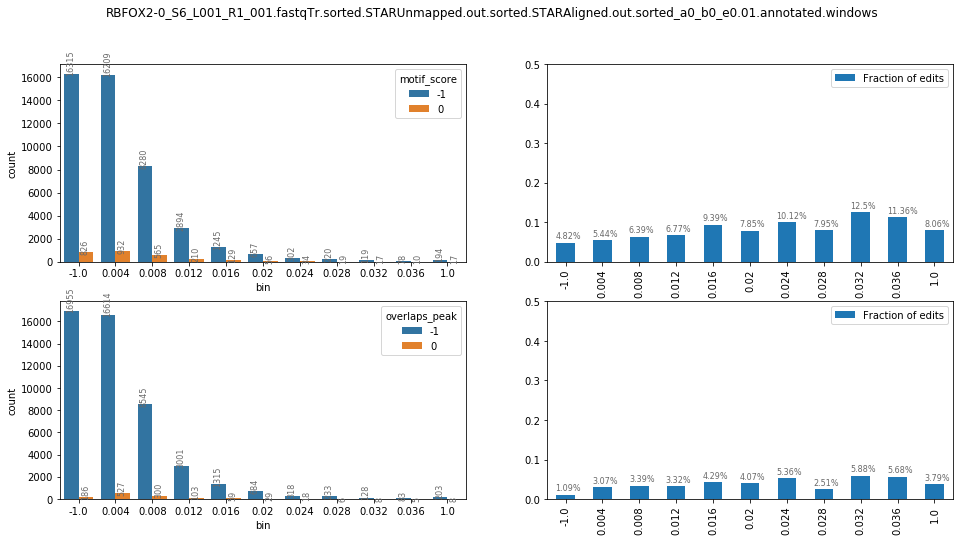

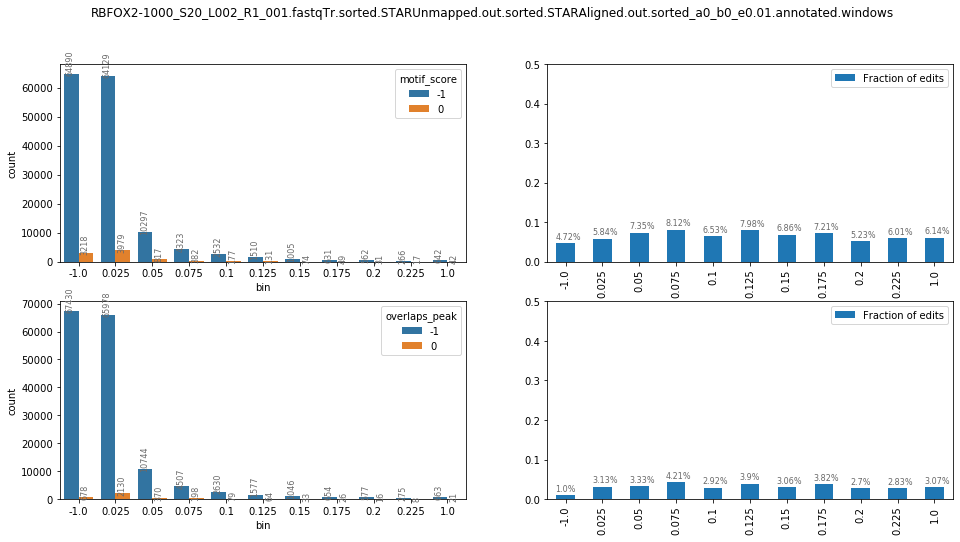

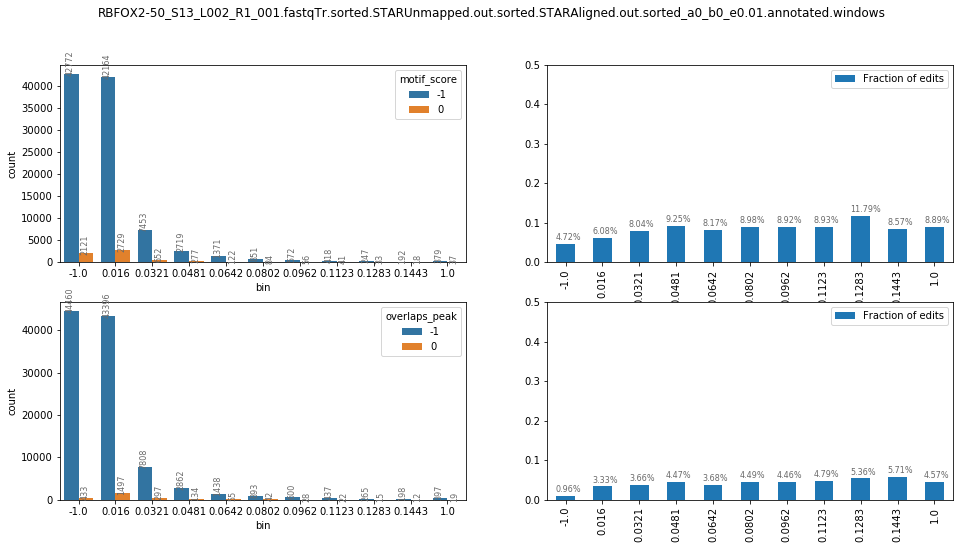

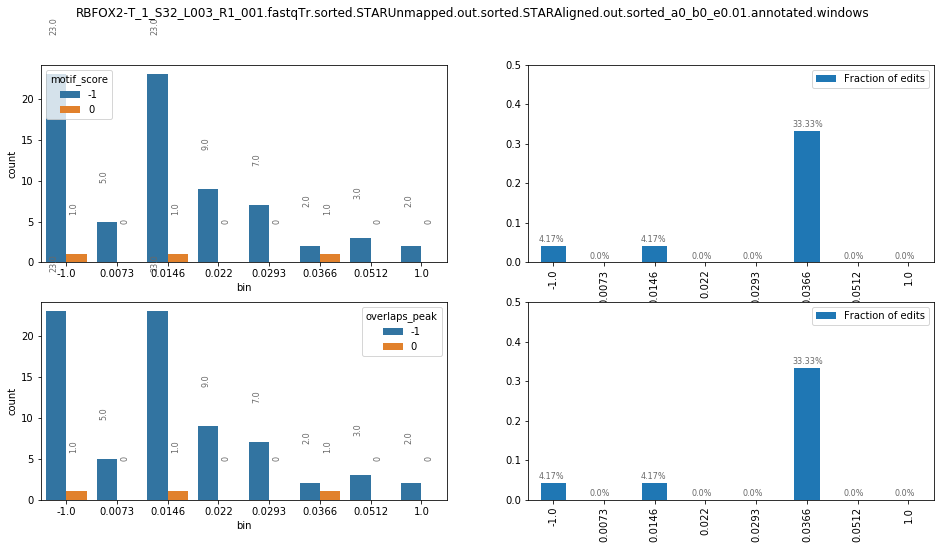

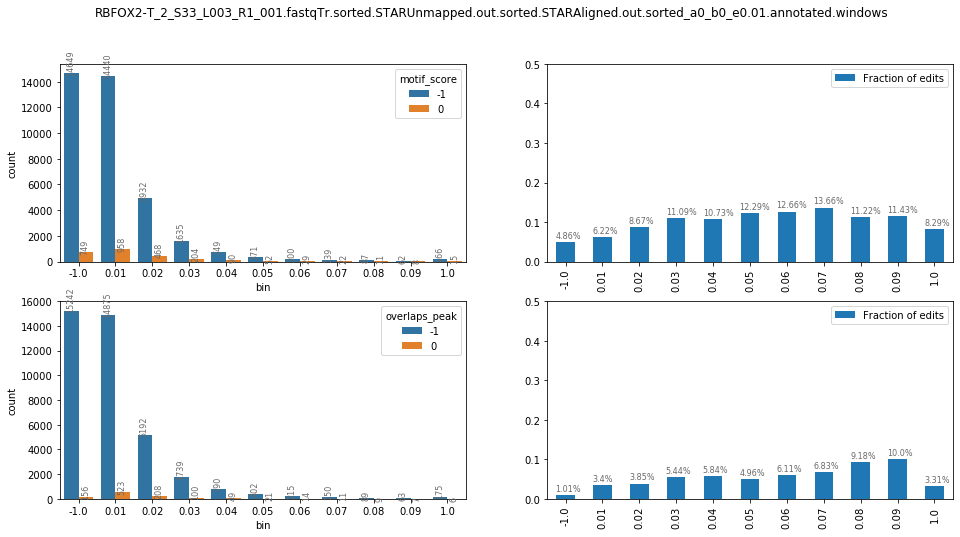

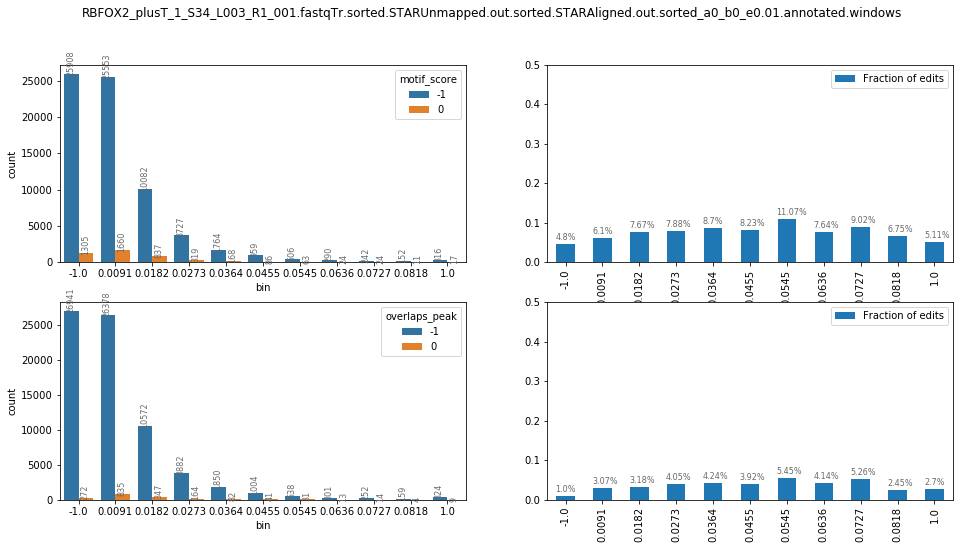

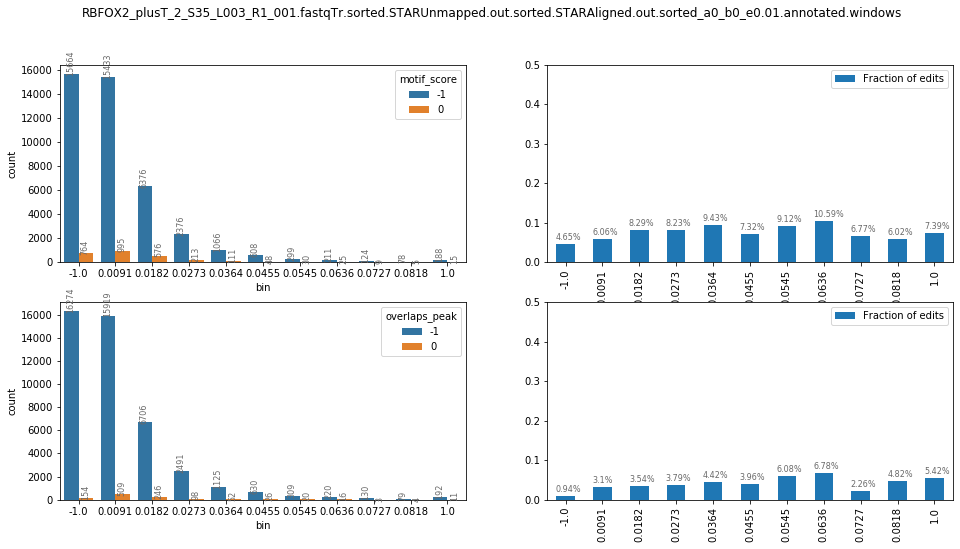

In [5]:
progress = tnrange(len(all_windows))
for window in all_windows:
    try:
        motifs_df, peaks_df = calculate_stuff(window, motif_file, peak_file, conf=0., score_column='edited_over_all_c')

        fig, axs = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=False)

        sns.countplot(data=motifs_df, x='bin', hue='motif_score', ax=axs[0][0])

        plot_percent(motifs_df, column='motif_score', ax=axs[0][1], ylim=(0, 0.5))
        sns.countplot(data=peaks_df, x='bin', hue='overlaps_peak', ax=axs[1][0])
        plot_percent(peaks_df, column='overlaps_peak', ax=axs[1][1], ylim=(0, 0.5))

        for ax in axs:
            # set individual bar lables using above list
            for i in ax[0].patches:
                if(np.isnan(i.get_height())):

                    # get_x pulls left or right; get_height pushes up or down
                    ax[0].text(
                        i.get_x()+.06, 
                        5, 
                        "0", 
                        fontsize=8,
                        color='dimgrey',
                        rotation='vertical'
                    )
                else:
                    # get_x pulls left or right; get_height pushes up or down
                    ax[0].text(
                        i.get_x()+.06, 
                        i.get_height()+5, 
                        str(round((i.get_height()), 2)), 
                        fontsize=8,
                        color='dimgrey',
                        rotation='vertical'
                    )
        fig.suptitle(os.path.splitext(os.path.basename(window))[0])
        fig.savefig(os.path.join(output_dir, '{}.svg'.format(os.path.splitext(os.path.basename(window))[0])))
    except Exception as e:
        print(e)
    progress.update(1)

In [6]:
df = pd.read_csv('/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_1/inputs/seRBFOX2_A_01.basedon_seRBFOX2_A_01.peaks.l2inputnormnew.bed.compressed.bed.annotated', sep='\t', names=['chrom','start','end','name','score','strand','region1','geneid'])

def get_region(row):
    try:
        return row['region1'].split('|')[0]
    except Exception:
        return 'intergenic'
    
df = df[(df['name']>=3) & (df['score']>=3)]
df['region'] = df.apply(get_region, axis=1)
df.shape

(3265, 9)